In [1]:
targetHeightToUse                = 427
referencePoolCombination         = [427]
shortOrLong                      = 'S'      # Default 'S'hort uses ONE FILE; 'L'ong EVERY FILE.
maskNumber                       = 2        # Default maskNumber = 2
userTestingNumberFrames          = 3        # Default userTestingNumberFrames = 3
VL                               = 3        # Default very verbose
# ( VL 0 Minimal ; VL 3 verbose and diagnostic, for development; VL 4 debugging / exhaustive / intensive, at pixel value level )

userLabel                        = "labelOWA100"  # User determined for now
targetName                       = "target" # User determined for now
dynMask4ple                      =  ( False , 0 , 0 , 0 )
dynMask4ple                      =  ( True , 1 , 0 , 0 )
runWedgeDecided                  = "A" # Default at least for the MinTest, MedTest, TypTest

## Demo of STIS.py for pyklip :
- This demo is set to produce the pyklip results for the V-AU-MIC star, which has a visible disk.
- You can run each of the V-AU-MIC fits files individually to see how the spider legs orient around the visible disk. (shortOrLong = 'S')
- You can run all of the V-AU-MIC fits files together. (shortOrLong = 'L')
- This is presently set to the dynamic mask (not an imported mask file) which has a large aperture determined by the OWA / Outer Working Angle.
- You'll see the alignment of the wedges with the various roll angles.

## What actions occur :
- Create a directory at the local level called "Runs".
- A directory for this run will be created automatically under the Runs/ directory.
- The target fileset is selected ; the reference file set is selected.
- The STIS.dataset function uploads the target and reference files,
    finds the largest amount of frame that can be shared (in the case of differently sized frames)
    converts saturated pixels, bad pixels, and masked pixels to nans...
- And presents the data in the format that pyklip can import.
- Pyklip creates a PSF library of everything, and creates a correlation matrix (which is additionally saved to file).
- The dataset class now deletes the reference data, leaving only the target data. (dataset1.filenames = dataset1.filenames[:tvrListIndex], etc)
- Pyklip now imports the edited dataset and isolates target data from reference data. (psflib.prepare_library ( dataset1 ))
- Pyklip now determines the modes of the PSF (parallelized.klip_dataset   ( ... ) )
- The median residual of the KL Modes is lastly plotted.

KEEP THIS ACKNOWLEDGEMENT BELOW THE VERY TOP / VERY FIRST CELL

OR ELSE THE MASTER WORKER LINK IS BROKEN

Open Source Code : https://pyklip.readthedocs.io/en/latest/

Open Source Code : https://github.com/seawander/centerRadon

In [2]:
import time
import os
from pyklip.instruments.utils.prntfFunction import prntf
# # from prntfFunction import prntf
# # from pyklip.instruments.utils.prntfFunction import prntf
# import pyklip.instruments.utils.prntfFunction
from datetime import datetime
folderDateTimeStamp = time.strftime(       "%H%M%S")
folderString        = folderDateTimeStamp # This can be improved later. For now, it is a minimum and unique.
# outputFolder        = "Runs/"+ folderString +"_"+ userLabel +"_"+ targetName + "/"
# os.makedirs ( outputFolder )
runPyklipStart      = datetime.now()
t                   = datetime.now().time()
s                   = t.strftime('%H:%M:%S.%f')
r                   = s[:-7]
prntf("work",20,"####################################################################")
prntf("work",20,"# B E G I N   W O R K E R   R U N _ P Y K L I P                    #")
prntf("work",20,"# B E G I N   W O R K E R   R U N _ P Y K L I P                    #")
prntf("work",20,"# Wall clock start time          : ", r                              )
prntf("work",20,"# folderDateTimeStamp            : ", folderDateTimeStamp            )
prntf("work",20,"# targetHeightToUse              : ", targetHeightToUse              )
prntf("work",20,"# referencePoolCombination       : ", referencePoolCombination       )
prntf("work",20,"# shortOrLong                    : ", shortOrLong                    )
prntf("work",20,"# maskNumber                     : ", maskNumber                     )
prntf("work",20,"# userTestingNumberFrames        : ", userTestingNumberFrames        )
# prntf("work",20,"# outputFolder                   : ", outputFolder                   )
prntf("work",20,"####################################################################")    

work     16  ####################################################################             
work     17  # B E G I N   W O R K E R   R U N _ P Y K L I P                    #             
work     18  # B E G I N   W O R K E R   R U N _ P Y K L I P                    #             
work     19  # Wall clock start time          :  13:26:28            
work     20  # folderDateTimeStamp            :  132628            
work     21  # targetHeightToUse              :  427            
work     22  # referencePoolCombination       :  [427]            
work     23  # shortOrLong                    :  S            
work     24  # maskNumber                     :  2            
work     25  # userTestingNumberFrames        :  3            
work     27  ####################################################################             


In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:101% !important; }</style>"))

In [4]:
approvedFlag            = False # Do this for first  runs when there is no prior list of approved frames.
zeroDataset_PAsFlag     = True  # On first run, yes, zero the PAs in order to get widescreen stddev
zeroOutputFrames_wcsOrientatFlag = False # On first run, no, do not zero the outputFrames wcsOrientat values
radonFlag               = True    
DatasetPlotFlag         = False
if approvedFlag        == False and radonFlag == True  : runNumberString     = "yRC1_" # yes radonCenter
if approvedFlag        == True  and radonFlag == True  : runNumberString     = "yRC2_"
percentileThreshold     = 90  # Top 90% means the 90% of all frames that have the lowest frame stddev
OutFrPlotFlag           = True      # Yes,       plot NMF residuals of all *incoming files                            
userDQmax               = pow ( 2, 14 )

In [5]:
import getpass
import sys
username            = "xyz" # test user non-existent
username            = getpass.getuser()
sys.path.insert(0,'../../Python/')
sys.path.insert(0,'../../Python/nmf_imaging/')   
sys.path.insert(0,'../../Python/NonnegMFPy/')
sys.path.insert(0,'../../Python/pyklip/')

In [6]:
import os
import math
import glob
import numpy as np
import importlib
import copy
from datetime import datetime
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.utils.data import download_file
from astropy.utils.data import get_pkg_data_filename
from astropy import stats
from pyklip.instruments.Instrument import GenericData # Not in run_nmf_imaging.ipynb
import pyklip.klip as klip
import pyklip.parallelized as parallelized
import pyklip.rdi as rdi
import pyklip.fakes as fakes
import pyklip.instruments.STIS as STIS

In [7]:
if   maskNumber          == 1:
    yesApplyFileMaskFlag  = False
elif maskNumber          == 2:
    yesApplyFileMaskFlag  = True
    fileMaskFilename      = "mask_narrow.fits" # 109 rows x 213 columns
    fileMaskLetter        = "NarMask_"
    fileMaskWedgeCode     = "A10"
divertFileMaskFlag        = False  # Pyklip requires False. NMF requires True.        
if yesApplyFileMaskFlag  == False :
    divertFileMaskFlag    = False
fileMaskHome              = os.path.curdir
fileMaskPath              = fileMaskHome + "/inputmasks/"
if yesApplyFileMaskFlag  == False :
    fileMaskLetter        = "NotMask_"
    fileMaskFQPN          = ""
else:    
    fileMaskFQPN          = fileMaskPath + fileMaskFilename

In [8]:
# S E T   I N P U T   F I L E S 

datapath                    = ""
fileFormat                  = "_flt"  # User sets this to "*" to stop filtering
fileExtension               = ".fits" # User sets this to "*" to stop filtering
filelistRef1                = []
userOutputPrefix            = ""
referenceHeightPrefix       = ""
    
if targetHeightToUse       == 427 :
    targetHeightPrefix      = "0427"
    targetPath              = datapath + "A10_427_VAUMIC_TRG/"
    targetName              = "VAUMIC_11030"
    if shortOrLong         == 'S' :               
        targetPrefix        = "odlv"
        wildcard1           = "01030" #
        wildcard1           = "03030" #
        wildcard1           = "05030" #
        wildcard1           = "11030" # Note that this roll angle places the visible disk _exactly_ behind the coronagraph
        
    if shortOrLong         == 'L' :               
        targetPrefix        = "*"
        wildcard1           = "*"
if 427 in referencePoolCombination :    
    referenceHeightPrefix   = referenceHeightPrefix + "X"
    referencePath           = datapath + "A10_427_HD145570_REF/"
    if shortOrLong         == 'S' :                   
        referencePrefix     = "odrq"
        wildcard3           = "03050" 
    if shortOrLong         == 'L' :                           
        referencePrefix     = "*"
        wildcard3           = "*" 
    filelistRef1.append (glob.glob ( referencePath + referencePrefix + wildcard3 + "*" + fileFormat + fileExtension )  )
    
outputFolder                = "Runs/"+ folderString +"_"+ userLabel +"_"+ targetName + "/" 
os.makedirs ( outputFolder )

userOutputPrefix            = runNumberString
filelistTrg                 = glob.glob ( targetPath   + targetPrefix + wildcard1 + "*" + fileFormat + fileExtension )
filelistTrg.sort()
filelistRef2                = []
for j in range(len(filelistRef1) ):
    for i in range(len(filelistRef1[j]) ):
        filelistRef2.append(filelistRef1[j][i])
filelistRef1.clear()        
filelistRef2.sort()

In [9]:
usertrgSCIListrefSCIList  = [ filelistTrg , filelistRef2 ]
corr_matrix_fits_filename = outputFolder + userOutputPrefix + "cm.fits"
userFinal_yExtent         =  427 # 427 is A10's maximum vertically symmetric rows 
userFinal_yExtent         =  110
userFinal_yExtent         = targetHeightToUse
userFinal_xExtent         = userFinal_yExtent
userFinal_xExtent         = 1024 # 1024 is 50CORON's default width
if runWedgeDecided       == "B" :
    userFinal_yExtent     = 1044

In [10]:
# S E T   I N N E R   W O R K I N G   A N G L E   and   O U T E R   W O R K I N G   A N G L E

# These are required by the pyklip Instrument class, which are not used by nmf_imaging.
# These are required even if we are not immediately doing planet injection.
# They will still need to be sent in even in the run_nmf_imaging notebook.

userSettingDatasetIWA    =  10
userSettingDatasetOWA    = 100 

In [11]:
pixelsfilename                   = "pixelCountFile"
pixelsfqpn                       = outputFolder + pixelsfilename  
uniquePixelsIngestedThisSession  = 0
uniquePixelsProcessedThisSession = 0

In [12]:
dataset1 = STIS.STISData   (
                            trgSCIListrefSCIList    = usertrgSCIListrefSCIList ,
                            outputFolder            = outputFolder             ,
                            xExtent                 = userFinal_xExtent        ,
                            yExtent                 = userFinal_yExtent        ,
                            IWA                     = userSettingDatasetIWA    ,
                            OWA                     = userSettingDatasetOWA    ,
                            yesApplyMaskFlag        = yesApplyFileMaskFlag     ,
                            divertMaskFlag          = divertFileMaskFlag       ,
                            maskFilename            = fileMaskFQPN             ,
                            DatasetPlotFlag         = DatasetPlotFlag          ,
                            DQmax                   = userDQmax                ,
                            VL                      = VL                       ,
                            approvedFlag            = approvedFlag             ,
                            radonFlag               = radonFlag                ,
                            userTestingNumberFrames = userTestingNumberFrames  ,
                            dynMask4ple             = dynMask4ple              ,
                            runWedgeDecided         = runWedgeDecided          ,
                            useRefandTrgFlag        = True                     ,
                            sizeMax                 = None                     ,
                            fileMaskWedgeCode       = 'A10'
)

stis    557    -1   VL                               :  3         
stis    558    -1   dynMask4ple                      :  (True, 1, 0, 0)         
stis    559    -1   fileMaskWedgeCode                :  A10         
stis    560    -1   runWedgeDecided                  :  A         
stis    561    -1   outputFolder                     :  Runs/132628_labelOWA100_VAUMIC_11030/         
stis    562    -1   yesApplyMaskFlag                 :  True         
stis    563    -1   divertMaskFlag                   :  False         
stis    570    -1   len(globFilesList)           :  0         
stis    571    -1   globFilesList                :  []         
stis    613    -1   END OF if approvedFlag == True :          
stis    618    -1   udh                              :  427         
stis    619    -1   udw                              :  1024         
stis    620    -1   hch                              :  427         
stis    621    -1   wcw                              :  1024         
stis

stis   1042    0   PROPAPER == 'WEDGEA1.0' and SIZAXIS2 == 427          
stis   1076    0   udh                                 :  109         
stis   1077    0   hch                                 :  426         
stis   1078    0   xStellarPoint                       :  310.505         
stis   1079    0   yStellarPoint                       :  213.569         
stis   1080    0   position                            :  (310.505, 213.569)         
stis   1081    0   hch                                 :  426 
        
stis   1087    0   len ( HDUList )                     :  10         
stis   1088    0   len ( HDUList ) - 1                 :  9         
stis   1104    0   iiiIndexMax                        :  9         
stis   1105    0   New Multiprocess Pool          
stis   1106    0   iterableIndicesPoll                 :  range(1, 9, 3)         
stis   1107    0   len(HDUSCIDataNPArray)              :  3         
stis   1108    0   allRadonCenterImports               :  [(309.68, 

stis    973    1   RADCENTX                                 : [ 310.04 ]        
stis    974    1   RADCENTY                                 : [ 212.41 ]        
stis    983    1   len(RADEC_trgref[tvr])                   :  1         
stis    943    1   dnfn                                     :  A10_427_HD145570_REF/odrq03050_flt.fits         
stis    944    1   iiiIndex                                 :  2         
stis    945    1   HDUList[iiiIndex].data[0][0]             :  2.441138         
stis    946    1   sys.getsizeof ( HDUList[iiiIndex].data ) :  112         
stis    943    1   dnfn                                     :  A10_427_HD145570_REF/odrq03050_flt.fits         
stis    944    1   iiiIndex                                 :  3         
stis    945    1   HDUList[iiiIndex].data[0][0]             :  512         
stis    946    1   sys.getsizeof ( HDUList[iiiIndex].data ) :  112         
stis    943    1   dnfn                                     :  A10_427_HD145570_REF

stis   1284    1   tvr :  1 , Approved :  3 , Rejected :  0     
stis   1297    -2   wcw                                 :  618         
stis   1298    -2   hch                                 :  426         
stis   1299    -2   len ( frameTupleList_trgref       ) :  2         
stis   1300    -2   len ( frameTupleList_trgref[0]    ) :  3         
stis   1303    -2   len ( frameTupleList_trgref[0][0] ) :  3         
stis   1306    -2   len ( frameTupleList_trgref[1]    ) :  3         
stis   1309    -2   len ( frameTupleList_trgref[1][0] ) :  3         
stis   1311    -2   wcw                                 :  618         
stis   1312    -2   hch                                 :  426         
stis   1315    -2   largestCommonSize                   :  (426, 618)         
stis   1319    -2   sizeMax                             :  (426, 618)         
stis   1325    -2   wcw                                 :  618         
stis   1326    -2   hch                                 :  426     


post   1647  len(ImplParallelizedResult) :  3            
post   1649  individualResult            : app_SCI_img, app_ERR_img             
stis   1453    1   hhhIndexMax :  2         


stis   1460    1   tvr implementation loop tvr implementation loop tvr implementation loop :  1         
stis   1460    1   tvr implementation loop tvr implementation loop tvr implementation loop :  1         
stis   1462    1   tvr implementation loop tvr implementation loop tvr implementation loop :  1         
stis   1462    1   tvr implementation loop tvr implementation loop tvr implementation loop :  1         
stis   1462    1   tvr implementation loop tvr implementation loop tvr implementation loop :  1         
stis   1462    1   tvr implementation loop tvr implementation loop tvr implementation loop :  1         
stis   1462    1   tvr implementation loop tvr implementation loop tvr implementation loop :  1         
stis   1462    1   tvr implementation loop tvr implementation loop tvr impleme


post   1647  len(ImplParallelizedResult) :  3            
post   1649  individualResult            : app_SCI_img, app_ERR_img             
stis   1680    -3   COMPLETED : for filelist in userTrgListRefList           


In [13]:
# This is to cause pyklip to not rotate the STIS-Up frames to their North-Up orientation.
# This is so we can get widescreen stddev with all available pixels.
# This is done only for the first run where we need to get widescreen / STIS-Up stddev on all the frames, 
# so that they can be sorted, so that the Top 90% can be retained.
# As designed, you run this once so that all frames are STIS-up, and get the stddev
# Then you run it a second time, and the approvedFrames generated from Run 1 are imported
# And the second run then does not need to prevent rotation of these frames
zeroDataset_PAsFlag = False
if zeroDataset_PAsFlag == True :
    for iiiIndex in range ( len ( dataset1._PAs ) ) :
        dataset1._PAs[iiiIndex] = 0

In [14]:
psflib = rdi.PSFLibrary (
        dataset1.input              , # psflib_imgs
        dataset1.centers[0]         , # aligned_center,
        dataset1.filenames          , # psflib_filenames,
        compute_correlation = True    # This means 'create new corr_matrix'
    )

psflib.save_correlation ( corr_matrix_fits_filename, clobber = True )

RDI_INIT 73 nfiles_data        :  6
RDI_INIT 74 nfiles_list        :  6
Making correlation matrix
0 1 2 3 4 5 
Done making correlation matrix


In [15]:
# ...Now read in the correlation matrix we already saved
# This can be sped up by a flag that bypasses the saving of the corr_matrix to file,
# but, leave it as it is for now...
# The corr_matrix itself can be diagnostic...
corr_matrix_hdulist = fits.open ( corr_matrix_fits_filename )
corr_matrix         = corr_matrix_hdulist[0].data

psflib = rdi.PSFLibrary (
        dataset1.input                    , # psflib_imgs
        dataset1.centers[0]               , # aligned_center
        dataset1.filenames                , # psflib_filenames
        correlation_matrix = corr_matrix
    )
del corr_matrix

corr_matrix_hdulist.close()

RDI_INIT 73 nfiles_data        :  6
RDI_INIT 74 nfiles_list        :  6
RDI_INIT 81 nfiles_correlation :  6


In [16]:
# Get the instance where the frames switch from target frames to reference frames...
for tvrListIndex in range ( len ( dataset1.tvrList ) ) :
    if dataset1.tvrList [ tvrListIndex ] != 0:
        break
        
# And then delete the reference frames from off the back of the array, 
#   leaving only the target frames
dataset1.filenames = dataset1.filenames[:tvrListIndex]
dataset1._centers  = dataset1._centers[:tvrListIndex]
dataset1._input    = dataset1._input[:tvrListIndex]
dataset1._PAs      = dataset1._PAs[:tvrListIndex]
dataset1._wcs      = dataset1._wcs[:tvrListIndex]
dataset1._wvs      = dataset1._wvs[:tvrListIndex]
dataset1._filenums = dataset1._filenums[:tvrListIndex]
dataset1.tvrList   = dataset1.tvrList[:tvrListIndex]
dataset1._error    = dataset1._error[:tvrListIndex]


In [17]:
# This step isolates target frames from reference frames in the psf library
psflib.prepare_library ( dataset1 )

RDI_PL 276 dataset_file_indices_in_lib.size :  3
RDI_PL 277 dataset_file_indices_in_lib.shape :  (3,)
RDI_PL 282 self.correlation.size :  18
RDI_PL 283 self.correlation.shape :  (3, 6)
RDI_PL 287 self.isgoodpsf :  [3 4 5]




/Users/rmt/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [18]:
# S E T   P A R A M E T E R S   F O R    P Y K L I P   P A R A L L E L I Z E D 
# See: https://pyklip.readthedocs.io/en/latest/klip_gpi.html
annuli      = 3                    # planets
subsections = 4                    # planets
annuli      = 1                    # disk
subsections = 1                    # disk
numbasis    = [ 1, 5, 10, 20, 50 ] # KL original suggested basis vectors to use to model the PSF.
numbasis    = [ 10, 15, 20 ] # use from here on out unless diag / devel / testing
maxnumbasis = 150                  # maximum number of most correlated PSFs to do PCA reconstruction with
movement    = 1

In [19]:
fileprefix     = userOutputPrefix + "STG2"

parallelized.klip_dataset   (
                                dataset1                             ,
                                outputdir      = outputFolder        ,
                                fileprefix     = fileprefix          ,  
                                annuli         = annuli              ,
                                subsections    = subsections         ,
                                numbasis       = numbasis            ,
                                maxnumbasis    = maxnumbasis         ,
                                mode           = "RDI"               ,
                                aligned_center = dataset1.centers[0] , # aligned_center ,
                                psf_library    = psflib              ,
                                movement       = movement
                            )

medianResidualPlot_yesRC1 = fits.getdata ( outputFolder + fileprefix + "-KLmodes-all.fits" )

1853 PARA_KLIP unique_wvs        :  [1.]     
1855 PARA_KLIP num_wvs           :  1     
1857 PARA_KLIP number_of_klmodes :  3     
1859 PARA_KLIP num_cubes         :  3     
1896 PARA_KLIP len ( dataset.output_centers) :  3     
1904 save_aligned:  False     
1910 PARA_KLIP wvindex   :  0     
1911 PARA_KLIP unique_wv :  1.0     
1922 PARA_KLIP dataset.filenums [thiswv] :  [0 0 0]     
1325 PARA_KLIP_PARA IWA :  10     
1326 PARA_KLIP_PARA OWA :  100     
1385 PARA_KLIP_PARA imgs.shape:  (3, 426, 618)     
1386 PARA_KLIP_PARA parallelized dims[1] * 1.0 426.0     
1387 PARA_KLIP_PARA parallelized dims[2] * 1.0 618.0     
1404 PARA_KLIP_PARA annuli         :  1     
1405 PARA_KLIP_PARA IWA            :  10     
1406 PARA_KLIP_PARA OWA            :  100     
1407 PARA_KLIP_PARA annuli_spacing :  constant     
718 KLIP_DAB annuli         :  1     
719 KLIP_DAB IWA            :  10     
720 KLIP_DAB OWA            :  100     
721 KLIP_DAB annuli_spacing :  constant     
749 KLIP_DAB min_wi

/Users/rmt/opt/anaconda3/lib/python3.7/site-packages/pyklip/klip.py:75: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, axis=axis)


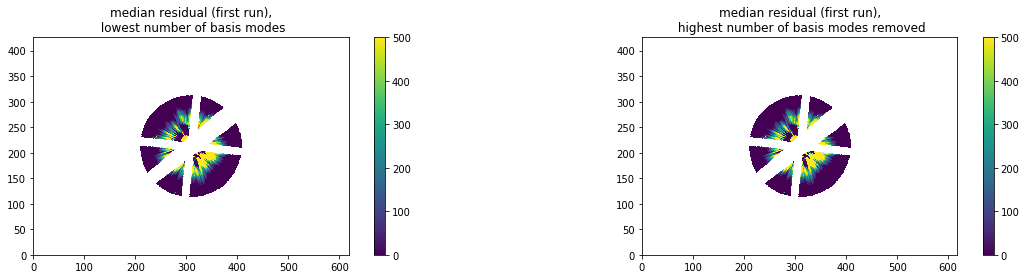

In [20]:
import matplotlib.pylab as plt
%matplotlib inline
plt.figure(figsize=[20,4])

plt.subplot(121)
plt.title("median residual (first run),\n lowest number of basis modes")
plt.imshow ( medianResidualPlot_yesRC1 [0,:,:],vmin=0,vmax=500 )
plt.xlim        ( [ 0, medianResidualPlot_yesRC1[0,:,:].shape[1] ] ) 
plt.ylim        ( [ 0, medianResidualPlot_yesRC1[0,:,:].shape[0] ] )
plt.colorbar()

plt.subplot(122)
plt.title("median residual (first run),\n highest number of basis modes removed")
plt.imshow ( medianResidualPlot_yesRC1 [-1,:,:],vmin=0,vmax=500 )
plt.xlim        ( [ 0, medianResidualPlot_yesRC1[-1,:,:].shape[1] ] ) 
plt.ylim        ( [ 0, medianResidualPlot_yesRC1[-1,:,:].shape[0] ] )
plt.colorbar()
plotName = runNumberString + "medres.png"

plt.savefig ( outputFolder + plotName , dpi = 150 )

In [21]:
outputFolderSplit       = outputFolder.split('/')
logFilePrefix           = outputFolderSplit[1]
logFilesFromPrnft       = glob.glob ( "logsFolder/*" )

for eachLogFile in logFilesFromPrnft : 
    eachLogFileBasename = os.path.basename ( eachLogFile )
    os.rename ("logsFolder/" + eachLogFileBasename, outputFolder + "/" + logFilePrefix + "_" + eachLogFileBasename) 